# July 15, 2024: summarize soft-comms

** AFNI terminates: If you can't explain it simply, you don't understand it well enough!  [638/823]

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import pickle 
import copy

from scipy import sparse, stats
from scipy.special import gammaln
import glob
from tqdm import tqdm
import ants
from nipype.interfaces import afni
from itertools import combinations, permutations, product


import graph_tool.all as gt

# from brainrender import Scene, actor

import vedo
vedo.settings.default_backend = 'k3d'
from vedo import Volume, Plotter

from brainglobe_utils.IO.image.load import load_nii

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import colorcet as cc

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import colorcet as cc
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

gt.seed_rng(args.SEED)
np.random.seed(args.SEED)

In [3]:
args.type = 'spatial'
args.roi_size = 225
args.maintain_symmetry = True
args.brain_div = 'whl'
args.num_rois = 162

DESC = (
    f'type-{args.type}'
    f'_size-{args.roi_size}'
    f'_symm-{args.maintain_symmetry}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
)

args.unit = 'seswise' # runwise/seswise/subwise : unit sample of dataset
args.denst = 25 # density of fc matrix

BASE_path = f'{os.environ["HOME"]}/mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = f'{BASE_path}/roi_results'
RECONST_method = '' #f'lds' #f'normal_dist'
if RECONST_method == '':
    GRAPH_type = f'correlation_graph'
    ROI_RESULTS_path = f'{ROI_path}/{DESC}/{args.unit}/{GRAPH_type}/density-{args.denst}'
    FC_path = f'{ROI_RESULTS_path}/corr_mats'
else: 
    GRAPH_type = f'reconstructed_graph/{RECONST_method}'
    ROI_RESULTS_path = f'{ROI_path}/{DESC}/{args.unit}/{GRAPH_type}'
    GRAPHS_path = f'{ROI_RESULTS_path}/graphs'

SBM_path = f'{ROI_RESULTS_path}/sbms'
NPY_path = f'{ROI_RESULTS_path}/npy'
os.system(f'mkdir -p {NPY_path}')
NII_path = f'{ROI_RESULTS_path}/niis'
os.system(f'mkdir -p {NII_path}/indiv')
os.system(f'mkdir -p {NII_path}/group/soft')
os.system(f'mkdir -p {NII_path}/group/entropy')
PNG_path = f'{ROI_RESULTS_path}/png'
os.system(f'mkdir -p {PNG_path}/group/morphospace')
HTML_path = f'{ROI_RESULTS_path}/htmls'
os.system(f'mkdir -p {HTML_path}/group/soft/indexes')
os.system(f'mkdir -p {HTML_path}/group/soft/partitions')
CSV_path = f'{ROI_RESULTS_path}/csv'
os.system(f'mkdir -p {CSV_path}/group/roi_order')

0

In [4]:
parcels_img = ants.image_read(f'{PARCELS_path}/{DESC}_desc-parcels.nii.gz')
parcels = parcels_img.numpy()
roi_labels = np.loadtxt(f'{PARCELS_path}/{DESC}_desc-labels.txt')

In [5]:
roi_names = pd.read_csv(f'{PARCELS_path}/{DESC}_desc-names.csv', names=['label', 'name'], delimiter='\t')

In [6]:
models_list = [
    ('', 'a'),
    ('nd', 'h'),
]

In [7]:
def load_modes(args, model):
    args.dc, args.sbm = model
    SBM = f'sbm-{args.dc}-{args.sbm}'
    with open(f'{NPY_path}/{SBM}_desc-group-modes.npy', 'rb') as f:
        [dfs, mode_df] = pickle.load(f)
    return args, SBM, dfs, mode_df

In [8]:
def get_labels_mat(args, SBM, idx_mode):
    labels_mat = pd.read_csv(
        f'{CSV_path}/group/roi_order/{SBM}_mode-{idx_mode}_desc-roi-order.csv',
        sep='\t',
    )
    labels_mat = labels_mat.sort_values(by='label')
    df = pd.DataFrame({
        'SBM': [SBM],
        'mode': [idx_mode],
        'labels_mat': [labels_mat],
    })
    return df

args, SBM, dfs, mode_df = load_modes(args, model=('', 'a'))
labels_df_a = get_labels_mat(args, SBM, 0)

labels_dfs = []
args, SBM, dfs, mode_df = load_modes(args, model=('nd', 'h'))
for idx_mode, row in mode_df.iterrows():
    df = get_labels_mat(args, SBM, idx_mode)
    labels_dfs.append(df)
mode_df['labels_mat'] = labels_dfs

In [9]:
labels_df_a['labels_mat'].to_list()[0][['0', 'label']]

,0,label
0,0,1
42,1,2
61,1,3
108,2,4
35,0,5
...,...,...
118,4,158
119,4,159
120,4,160
121,4,161


In [10]:
mode_df

,mode_id,mode,omega,sigma,ratio,b,labels_mat
0,0,<graph_tool.inference.partition_modes.Partitio...,0.563353,0.465163,1.211087,"[[0, 1, 1, 2, 3, 3, 4, 0, 0, 4, 3, 1, 3, 2, 0,...",SBM mode ...
1,1,<graph_tool.inference.partition_modes.Partitio...,0.362573,0.460341,0.787618,"[[0, 4, 1, 2, 6, 3, 4, 6, 3, 12, 3, 1, 0, 6, 3...",SBM mode ...
2,2,<graph_tool.inference.partition_modes.Partitio...,0.070175,0.350137,0.200423,"[[3, 1, 18, 2, 6, 6, 4, 0, 1, 12, 3, 1, 3, 0, ...",SBM mode ...
3,3,<graph_tool.inference.partition_modes.Partitio...,0.003899,0.308642,0.012632,"[[3, 4, 4, 0, 3, 3, 4, 0, 0, 4, 3, 4, 0, 3, 3,...",SBM mode ...


In [11]:
args.max_h_label = {}
for level in ['0', '1']:
    max_h0_labels = []
    for idx, row in mode_df.iterrows():
        max_h0_labels.append(np.max(row['labels_mat']['labels_mat'][0][level].unique())+1)    
    args.max_h_label[level] = np.max(max_h0_labels)
args.max_h_label

{'0': 21, '1': 4}

In [12]:
def a0h1_props_mat(args, labels_df):
    props_mat = np.zeros((len(labels_df['0'].unique()), args.max_h_label['1']))
    for hl in labels_df['1'].unique():
        als, lcs = np.unique(labels_df[labels_df['1'] == hl]['0'].to_list(), return_counts=True)
        props_mat[als, hl] = lcs
    # props_mat = props_mat / np.sum(props_mat, axis=-1)[:, np.newaxis]
    return np.nan_to_num(props_mat)

def h0a0_props_mat(args, labels_df):
    props_mat = np.zeros((args.max_h_label['0'], np.max(labels_df['0_a'].unique())+1))
    for al in labels_df['0_a'].unique():
        hls, lcs = np.unique(labels_df[labels_df['0_a'] == al]['0_h'].to_list(), return_counts=True)
        props_mat[hls, al] = lcs
    # props_mat = props_mat / np.sum(props_mat, axis=-1)[:, np.newaxis]
    return np.nan_to_num(props_mat)

In [13]:
# compare a_0 with h_1
props_mats = []
a0 = labels_df_a['labels_mat'].to_list()[0][['0', 'label']]
for idx_mode, row in mode_df.iterrows():
    h1 = row['labels_mat']['labels_mat'].to_list()[0][['1', 'label']]
    labels_df = pd.merge(a0, h1)[['0', '1', 'label']]
    props_mats.append(a0h1_props_mat(args, labels_df))
mode_df['a0h1'] = props_mats

In [14]:
# compare h_0 with a_0
props_mats = []
a0 = labels_df_a['labels_mat'].to_list()[0][['0', 'label']]
for idx_mode, row in tqdm(mode_df.iterrows()):
    h0 = row['labels_mat']['labels_mat'].to_list()[0][['0', 'label']]
    labels_df = pd.merge(
        a0, h0, 
        on='label',
        suffixes=['_a', '_h'],
    )
    # display(labels_df)
    props_mats.append(h0a0_props_mat(args, labels_df))
mode_df['h0a0'] = props_mats

4it [00:00, 135.43it/s]


[Text(0.5, 1.0, 'proportions'),
 Text(13.25, 0.5, 'sbm--a'),
 Text(0.5, 27.64999999999999, 'sbm-nd-h, level 1')]

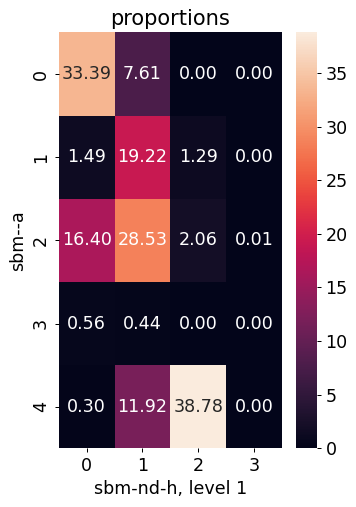

In [15]:
props_mat = []
for idx, row in mode_df.iterrows():
    props_mat += [row['a0h1'] * row['omega']]
props_mat = np.sum(props_mat, axis=0)

nrows = 1
ncols = 1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 6*nrows), dpi=90)
ax = axs
sns.heatmap(props_mat, ax=ax, annot=True, fmt='.2f')
ax.set(title=f'proportions', ylabel='sbm--a', xlabel=f'sbm-nd-h, level 1')

[Text(0.5, 1.0, 'proportions'),
 Text(0.5, 87.04999999999998, 'sbm--a'),
 Text(13.25, 0.5, 'sbm-nd-h, level 0')]

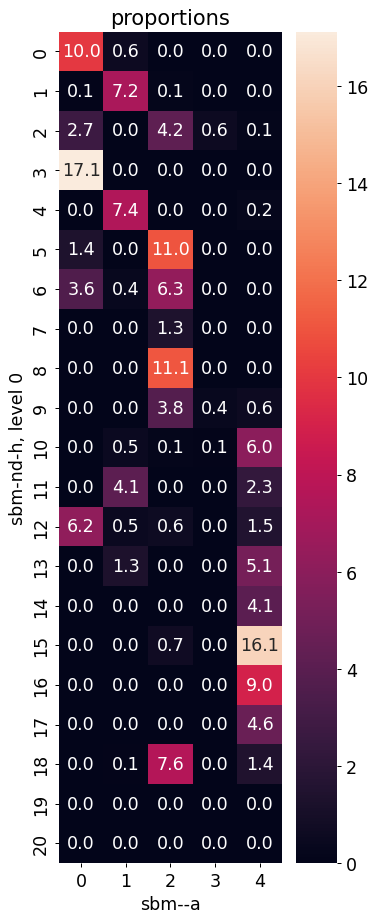

In [16]:
props_mat = []
for idx, row in mode_df.iterrows():
    props_mat += [row['h0a0'] * row['omega']]
props_mat = np.sum(props_mat, axis=0)

nrows = 1
ncols = 1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 12*nrows), dpi=90)
ax = axs
sns.heatmap(props_mat, ax=ax, annot=True, fmt='.1f')
ax.set(title=f'proportions', xlabel='sbm--a', ylabel=f'sbm-nd-h, level 0')

---

In [17]:
# entropy summaries

In [18]:
level = 0
soft_comms_img = f'{NII_path}/group/soft/sbm-{args.dc}-{args.sbm}_level-{level}_desc-soft-comms.nii.gz'
soft_comms_img = ants.image_read(soft_comms_img)
soft_comms_img = soft_comms_img.numpy()

soft_comms = np.zeros((args.num_rois, soft_comms_img.shape[-1]))
for idx_comm in range(soft_comms.shape[-1]):
    E = soft_comms_img[:, :, :, idx_comm]
    for idx, roi in enumerate(roi_labels):
        val = np.unique((parcels == roi) * E)
        val = val[1] if len(val) > 1 else val
        soft_comms[idx, idx_comm] = val

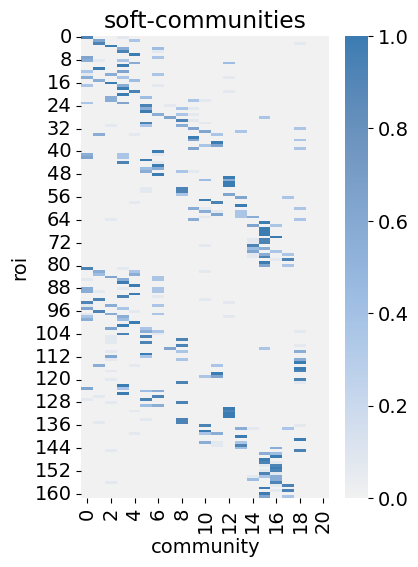

In [19]:
def plot_soft_comms(args, soft_comms):
    fig, axs = plt.subplots(1, 1, figsize=(4, 6))
    ax = axs
    sns.heatmap(soft_comms, ax=ax, cmap=cc.cm.CET_L12)#'viridis')
    ax.set(xlabel=f'community', ylabel=f'roi', title=f'soft-communities')
    
plot_soft_comms(args, soft_comms)

In [20]:
level = 0
entropy_img = f'{NII_path}/group/entropy/sbm-{args.dc}-{args.sbm}_level-{level}_desc-ent.nii.gz'
entropy_img = ants.image_read(entropy_img).numpy()

ent = np.zeros((args.num_rois,))
for idx, roi in enumerate(roi_labels):
    val = np.unique((parcels == roi) * entropy_img)
    val = val[1] if len(val) > 1 else val
    ent[idx] = val

In [21]:
def find_index_sets(x, roi_labels):    
    roi_sets_df = []
    for val in np.unique(x):
        roi_idxs = np.where(ent == val)[0]
        df = pd.DataFrame({
            'ent': [val],
            'roi_idxs': [roi_idxs],
            'rois': [roi_labels[roi_idxs]],
            'num_rois': [len(roi_idxs)],
        })
        roi_sets_df.append(df)
    roi_sets_df = pd.concat(roi_sets_df).reset_index(drop=True)    
    return roi_sets_df

roi_sets_df = find_index_sets(ent, roi_labels)
roi_sets_df

,ent,roi_idxs,rois,num_rois
0,0.000000,"[6, 10, 20, 26, 35, 37, 40, 43, 45, 59, 67, 68...","[7.0, 11.0, 21.0, 27.0, 36.0, 38.0, 41.0, 44.0...",23
1,0.008381,"[3, 11, 16, 18, 48, 49, 51, 52, 57, 65, 69, 70...","[4.0, 12.0, 17.0, 19.0, 49.0, 50.0, 52.0, 53.0...",24
2,0.083459,"[5, 19, 24, 30, 44, 58, 72, 78, 81, 91, 92, 10...","[6.0, 20.0, 25.0, 31.0, 45.0, 59.0, 73.0, 79.0...",28
3,0.086730,"[0, 29, 71, 93, 156]","[1.0, 30.0, 72.0, 94.0, 157.0]",5
4,0.091747,"[2, 53, 54, 73, 77, 96, 126, 131, 135, 143, 15...","[3.0, 54.0, 55.0, 74.0, 78.0, 97.0, 127.0, 132...",12
5,0.215102,"[7, 23, 28, 32, 36, 38, 39, 42, 66, 95, 109, 119]","[8.0, 24.0, 29.0, 33.0, 37.0, 39.0, 40.0, 43.0...",12
6,0.215814,"[1, 12, 33, 56, 80, 102, 112, 123, 161]","[2.0, 13.0, 34.0, 57.0, 81.0, 103.0, 113.0, 12...",9
7,0.222906,"[55, 62, 75, 84]","[56.0, 63.0, 76.0, 85.0]",4
8,0.224690,"[4, 9]","[5.0, 10.0]",2
9,0.225027,"[15, 21, 46, 74, 83, 99, 124, 155]","[16.0, 22.0, 47.0, 75.0, 84.0, 100.0, 125.0, 1...",8


In [22]:
num_comms = []
comms = []
for idx, row in roi_sets_df.iterrows():
    X = soft_comms[row['roi_idxs'], :]
    X = (X > 0).astype(int)
    num_comms += [np.sum(X, axis=-1)]
    
    comms_ = []
    for i in range(X.shape[0]):
        comms_ += [np.where(X[i, :])[0]]
    comms_ = np.stack(comms_)
    comms += [comms_]
    
roi_sets_df['num_comms'] = num_comms
roi_sets_df['comms'] = comms

In [23]:
roi_sets_df

,ent,roi_idxs,rois,num_rois,num_comms,comms
0,0.000000,"[6, 10, 20, 26, 35, 37, 40, 43, 45, 59, 67, 68...","[7.0, 11.0, 21.0, 27.0, 36.0, 38.0, 41.0, 44.0...",23,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[4], [3], [3], [5], [9], [11], [6], [5], [6],..."
1,0.008381,"[3, 11, 16, 18, 48, 49, 51, 52, 57, 65, 69, 70...","[4.0, 12.0, 17.0, 19.0, 49.0, 50.0, 52.0, 53.0...",24,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[[0, 2], [1, 4], [0, 2], [3, 12], [3, 6], [3, ..."
2,0.083459,"[5, 19, 24, 30, 44, 58, 72, 78, 81, 91, 92, 10...","[6.0, 20.0, 25.0, 31.0, 45.0, 59.0, 73.0, 79.0...",28,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[[3, 6], [4, 12], [5, 7], [5, 10], [3, 6], [4,..."
3,0.086730,"[0, 29, 71, 93, 156]","[1.0, 30.0, 72.0, 94.0, 157.0]",5,"[2, 2, 2, 2, 2]","[[0, 3], [8, 9], [14, 15], [0, 12], [2, 16]]"
4,0.091747,"[2, 53, 54, 73, 77, 96, 126, 131, 135, 143, 15...","[3.0, 54.0, 55.0, 74.0, 78.0, 97.0, 127.0, 132...",12,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]","[[1, 4, 18], [5, 8, 9], [5, 8, 9], [9, 10, 14]..."
5,0.215102,"[7, 23, 28, 32, 36, 38, 39, 42, 66, 95, 109, 119]","[8.0, 24.0, 29.0, 33.0, 37.0, 39.0, 40.0, 43.0...",12,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[[0, 6], [0, 3], [7, 15], [9, 18], [9, 18], [1..."
6,0.215814,"[1, 12, 33, 56, 80, 102, 112, 123, 161]","[2.0, 13.0, 34.0, 57.0, 81.0, 103.0, 113.0, 12...",9,"[2, 2, 2, 2, 2, 2, 2, 2, 2]","[[1, 4], [0, 3], [10, 13], [13, 17], [15, 17],..."
7,0.222906,"[55, 62, 75, 84]","[56.0, 63.0, 76.0, 85.0]",4,"[3, 3, 3, 3]","[[8, 12, 13], [4, 11, 13], [5, 14, 16], [0, 2,..."
8,0.224690,"[4, 9]","[5.0, 10.0]",2,"[2, 2]","[[3, 6], [4, 12]]"
9,0.225027,"[15, 21, 46, 74, 83, 99, 124, 155]","[16.0, 22.0, 47.0, 75.0, 84.0, 100.0, 125.0, 1...",8,"[2, 2, 2, 2, 2, 2, 2, 2]","[[1, 4], [2, 5], [5, 6], [14, 15], [1, 4], [0,..."


In [24]:
roi_sets_df.iloc[-1]['comms']

array([[ 0,  2,  3,  6],
       [ 0,  3,  6, 12],
       [ 2,  9, 10, 12],
       [ 0,  6,  8,  9],
       [ 4, 10, 11, 13],
       [10, 13, 14, 17],
       [14, 15, 17, 20],
       [ 0,  2,  3,  6],
       [ 5,  6, 13, 18],
       [ 4, 10, 11, 13]])

In [25]:
roi_sets_df.iloc[0]['comms']

array([[ 4],
       [ 3],
       [ 3],
       [ 5],
       [ 9],
       [11],
       [ 6],
       [ 5],
       [ 6],
       [13],
       [15],
       [15],
       [ 3],
       [ 4],
       [ 3],
       [18],
       [ 3],
       [ 3],
       [13],
       [18],
       [16],
       [15],
       [16]])